In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from ComputationalGraphPrimer import *
import operator

In [2]:
class SGDPlus(ComputationalGraphPrimer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def run_training_loop_one_neuron_model(self, training_data,mu=0.0,SGDplus=False):
        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                

        ##My input start
        self.bias_update = 0.0
        self.step = [0]*(len(self.learnable_params)+1)
        self.mu = mu if SGDplus else 0.0      
        
        ##My input end
        
        
        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)     ## BACKPROP loss

        return loss_running_record


    def forward_prop_one_neuron_model(self, data_tuples_in_batch):
        """
        Forward propagates the batch data through the neural network according to the equations on
        Slide 50 of my Week 3 slides.

        As the one-neuron model is characterized by a single expression, the main job of this function is
        to evaluate that expression for each data tuple in the incoming batch.  The resulting output is
        fed into the sigmoid activation function and the partial derivative of the sigmoid with respect
        to its input calculated.
        """
        output_vals = []
        deriv_sigmoids = []
        for vals_for_input_vars in data_tuples_in_batch:
            input_vars = self.independent_vars                   ## This is a list of vars for the input nodes. For the
                                                                 ##   the One-Neuron example in the Examples directory
                                                                 ##   this is just the list [xa, xb, xc, xd]
            vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))   ## The current values at input

            exp_obj = self.exp_objects[0]                        ## To understand this, first see the definition of the
                                                                 ##   Exp class (search for the string "class Exp").
                                                                 ##   Each expression that defines the neural network is
                                                                 ##   represented by one Exp instance by the parser.
            output_val = self.eval_expression(exp_obj.body , vals_for_input_vars_dict, self.vals_for_learnable_params)

            ## [Search for "self.bias" in this file.]  As mentioned earlier, adding bias improves class discrimination:
            output_val = output_val + self.bias

            output_val = 1.0 / (1.0 + np.exp(-1.0 * output_val))   ## Apply sigmoid activation (output confined to [0.0,1.0] interval) 

            deriv_sigmoid = output_val * (1.0 - output_val)        ## See Slide 59 for why we need partial deriv of Sigmoid at input point

            output_vals.append(output_val)                         ## Collect output values for different input samples in batch

            deriv_sigmoids.append(deriv_sigmoid)                   ## Collect the Sigmoid derivatives for each input sample in batch
                                                                   ##   The derivatives that are saved during forward prop are shown on Slide 59.
        return output_vals, deriv_sigmoids


    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid):
        """
        As should be evident from the syntax used in the following call to backprop function,

           self.backprop_and_update_params_one_neuron_model( y_error_avg, data_tuple_avg, deriv_sigmoid_avg)
                                                                     ^^^             ^^^                ^^^
        the values fed to the backprop function for its three arguments are averaged over the training 
        samples in the batch.  This in keeping with the spirit of SGD that calls for averaging the 
        information retained in the forward propagation over the samples in a batch.

        See Slide 59 of my Week 3 slides for the math of back propagation for the One-Neuron network.
        """
        input_vars = self.independent_vars
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        for i,param in enumerate(self.vals_for_learnable_params):
            ## My change start
            self.step[i] = (self.mu*self.step[i]) +  y_error * vals_for_input_vars_dict[input_vars[i]] * deriv_sigmoid
            
            ## Update the learnable parameters
            self.vals_for_learnable_params[param] += self.learning_rate*self.step[i]
            
        ## Update the bias
        self.bias_update = (self.mu*self.bias_update) + y_error * deriv_sigmoid
        self.bias += self.learning_rate*self.bias_update   
            ##My change end

In [3]:
class Adam(ComputationalGraphPrimer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def run_training_loop_one_neuron_model(self, training_data,beta1,beta2):
        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                

        ##My input start
        self.bias_m = 0.0
        self.bias_v = 0.0
        
        self.bias_mh = 0.0
        self.bias_vh = 0.0
        
        self.step_m = [0]*(len(self.learnable_params)+1)
        self.step_v = [0]*(len(self.learnable_params)+1) 
        self.step_mh = [0]*(len(self.learnable_params)+1)
        self.step_vh = [0]*(len(self.learnable_params)+1) 
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = 0
        
        ##My input end
        
        
        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            self.m = i+1
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)     ## BACKPROP loss

        return loss_running_record


    def forward_prop_one_neuron_model(self, data_tuples_in_batch):
        """
        Forward propagates the batch data through the neural network according to the equations on
        Slide 50 of my Week 3 slides.

        As the one-neuron model is characterized by a single expression, the main job of this function is
        to evaluate that expression for each data tuple in the incoming batch.  The resulting output is
        fed into the sigmoid activation function and the partial derivative of the sigmoid with respect
        to its input calculated.
        """
        output_vals = []
        deriv_sigmoids = []
        for vals_for_input_vars in data_tuples_in_batch:
            input_vars = self.independent_vars                   ## This is a list of vars for the input nodes. For the
                                                                 ##   the One-Neuron example in the Examples directory
                                                                 ##   this is just the list [xa, xb, xc, xd]
            vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))   ## The current values at input

            exp_obj = self.exp_objects[0]                        ## To understand this, first see the definition of the
                                                                 ##   Exp class (search for the string "class Exp").
                                                                 ##   Each expression that defines the neural network is
                                                                 ##   represented by one Exp instance by the parser.
            output_val = self.eval_expression(exp_obj.body , vals_for_input_vars_dict, self.vals_for_learnable_params)

            ## [Search for "self.bias" in this file.]  As mentioned earlier, adding bias improves class discrimination:
            output_val = output_val + self.bias

            output_val = 1.0 / (1.0 + np.exp(-1.0 * output_val))   ## Apply sigmoid activation (output confined to [0.0,1.0] interval) 

            deriv_sigmoid = output_val * (1.0 - output_val)        ## See Slide 59 for why we need partial deriv of Sigmoid at input point

            output_vals.append(output_val)                         ## Collect output values for different input samples in batch

            deriv_sigmoids.append(deriv_sigmoid)                   ## Collect the Sigmoid derivatives for each input sample in batch
                                                                   ##   The derivatives that are saved during forward prop are shown on Slide 59.
        return output_vals, deriv_sigmoids


    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid):
        """
        As should be evident from the syntax used in the following call to backprop function,

           self.backprop_and_update_params_one_neuron_model( y_error_avg, data_tuple_avg, deriv_sigmoid_avg)
                                                                     ^^^             ^^^                ^^^
        the values fed to the backprop function for its three arguments are averaged over the training 
        samples in the batch.  This in keeping with the spirit of SGD that calls for averaging the 
        information retained in the forward propagation over the samples in a batch.

        See Slide 59 of my Week 3 slides for the math of back propagation for the One-Neuron network.
        """
        input_vars = self.independent_vars
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        for i,param in enumerate(self.vals_for_learnable_params):
            ## My change start
            self.step_m[i] = (self.beta1*self.step_m[i]) + (1-self.beta1)*(y_error * vals_for_input_vars_dict[input_vars[i]] * deriv_sigmoid)
            self.step_mh[i] = self.step_m[i]/(1-self.beta1**self.m)
            
            self.step_v[i] = (self.beta2*self.step_v[i]) + (1-self.beta2)*((y_error * vals_for_input_vars_dict[input_vars[i]] * deriv_sigmoid)**2)
            self.step_vh[i] = self.step_v[i]/(1-self.beta2**self.m)

            ## Update the learnable parameters
            self.vals_for_learnable_params[param] += self.learning_rate * (self.step_mh[i]/(np.sqrt(self.step_vh[i])+10**-6))
            
        ## Update the bias
        self.bias_m = (self.beta1*self.bias_m) + (1-self.beta1)*(y_error * deriv_sigmoid)
        self.bias_mh = self.bias_m/(1-self.beta1**self.m)
        self.bias_v = (self.beta2*self.bias_v) + (1-self.beta2)*((y_error * deriv_sigmoid)**2)
        self.bias_vh = self.bias_v/(1-self.beta2**self.m)
        self.bias += self.learning_rate * (self.bias_m/(np.sqrt(self.bias_v)+10**-6)) 
            ##My change end

In [4]:
cgp1 = SGDPlus(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = 1e-2,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


cgp1.parse_expressions()
training_data1 = cgp1.gen_training_data()



all variables: {'xa', 'xb', 'xc', 'xw', 'xd'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xb', 'xc', 'xd']


leads_to dictionary: {'xa': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}, 'xw': set(), 'xd': {'xw'}}


In [5]:
cgp2 = Adam(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = 1e-2,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


cgp2.parse_expressions()
training_data2 = cgp2.gen_training_data()



all variables: {'xa', 'xb', 'xc', 'xw', 'xd'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xb', 'xc', 'xd']


leads_to dictionary: {'xa': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}, 'xw': set(), 'xd': {'xw'}}


[iter=1]  loss = 0.0030
[iter=101]  loss = 0.3332
[iter=201]  loss = 0.3052
[iter=301]  loss = 0.3036
[iter=401]  loss = 0.2904
[iter=501]  loss = 0.2811
[iter=601]  loss = 0.2984
[iter=701]  loss = 0.2837
[iter=801]  loss = 0.2645
[iter=901]  loss = 0.2650
[iter=1001]  loss = 0.2590
[iter=1101]  loss = 0.2575
[iter=1201]  loss = 0.2500
[iter=1301]  loss = 0.2474
[iter=1401]  loss = 0.2500
[iter=1501]  loss = 0.2489
[iter=1601]  loss = 0.2460
[iter=1701]  loss = 0.2482
[iter=1801]  loss = 0.2506
[iter=1901]  loss = 0.2489
[iter=2001]  loss = 0.2420
[iter=2101]  loss = 0.2422
[iter=2201]  loss = 0.2430
[iter=2301]  loss = 0.2449
[iter=2401]  loss = 0.2409
[iter=2501]  loss = 0.2451
[iter=2601]  loss = 0.2415
[iter=2701]  loss = 0.2465
[iter=2801]  loss = 0.2437
[iter=2901]  loss = 0.2448
[iter=3001]  loss = 0.2467
[iter=3101]  loss = 0.2458
[iter=3201]  loss = 0.2479
[iter=3301]  loss = 0.2483
[iter=3401]  loss = 0.2442
[iter=3501]  loss = 0.2442
[iter=3601]  loss = 0.2446
[iter=3701]  

[iter=29901]  loss = 0.2313
[iter=30001]  loss = 0.2299
[iter=30101]  loss = 0.2294
[iter=30201]  loss = 0.2304
[iter=30301]  loss = 0.2304
[iter=30401]  loss = 0.2298
[iter=30501]  loss = 0.2293
[iter=30601]  loss = 0.2271
[iter=30701]  loss = 0.2288
[iter=30801]  loss = 0.2296
[iter=30901]  loss = 0.2313
[iter=31001]  loss = 0.2274
[iter=31101]  loss = 0.2278
[iter=31201]  loss = 0.2284
[iter=31301]  loss = 0.2297
[iter=31401]  loss = 0.2287
[iter=31501]  loss = 0.2295
[iter=31601]  loss = 0.2280
[iter=31701]  loss = 0.2282
[iter=31801]  loss = 0.2280
[iter=31901]  loss = 0.2276
[iter=32001]  loss = 0.2288
[iter=32101]  loss = 0.2303
[iter=32201]  loss = 0.2287
[iter=32301]  loss = 0.2294
[iter=32401]  loss = 0.2275
[iter=32501]  loss = 0.2286
[iter=32601]  loss = 0.2300
[iter=32701]  loss = 0.2279
[iter=32801]  loss = 0.2289
[iter=32901]  loss = 0.2294
[iter=33001]  loss = 0.2286
[iter=33101]  loss = 0.2271
[iter=33201]  loss = 0.2293
[iter=33301]  loss = 0.2276
[iter=33401]  loss =

[iter=19601]  loss = 0.1785
[iter=19701]  loss = 0.1758
[iter=19801]  loss = 0.1780
[iter=19901]  loss = 0.1819
[iter=20001]  loss = 0.1712
[iter=20101]  loss = 0.1775
[iter=20201]  loss = 0.1719
[iter=20301]  loss = 0.1705
[iter=20401]  loss = 0.1739
[iter=20501]  loss = 0.1763
[iter=20601]  loss = 0.1732
[iter=20701]  loss = 0.1767
[iter=20801]  loss = 0.1775
[iter=20901]  loss = 0.1765
[iter=21001]  loss = 0.1752
[iter=21101]  loss = 0.1806
[iter=21201]  loss = 0.1772
[iter=21301]  loss = 0.1750
[iter=21401]  loss = 0.1710
[iter=21501]  loss = 0.1754
[iter=21601]  loss = 0.1661
[iter=21701]  loss = 0.1707
[iter=21801]  loss = 0.1725
[iter=21901]  loss = 0.1713
[iter=22001]  loss = 0.1718
[iter=22101]  loss = 0.1738
[iter=22201]  loss = 0.1750
[iter=22301]  loss = 0.1716
[iter=22401]  loss = 0.1729
[iter=22501]  loss = 0.1755
[iter=22601]  loss = 0.1668
[iter=22701]  loss = 0.1690
[iter=22801]  loss = 0.1733
[iter=22901]  loss = 0.1723
[iter=23001]  loss = 0.1682
[iter=23101]  loss =

[iter=9401]  loss = 0.1457
[iter=9501]  loss = 0.1440
[iter=9601]  loss = 0.1545
[iter=9701]  loss = 0.1634
[iter=9801]  loss = 0.1532
[iter=9901]  loss = 0.1543
[iter=10001]  loss = 0.1500
[iter=10101]  loss = 0.1541
[iter=10201]  loss = 0.1480
[iter=10301]  loss = 0.1501
[iter=10401]  loss = 0.1530
[iter=10501]  loss = 0.1650
[iter=10601]  loss = 0.1547
[iter=10701]  loss = 0.1590
[iter=10801]  loss = 0.1503
[iter=10901]  loss = 0.1517
[iter=11001]  loss = 0.1588
[iter=11101]  loss = 0.1508
[iter=11201]  loss = 0.1469
[iter=11301]  loss = 0.1556
[iter=11401]  loss = 0.1608
[iter=11501]  loss = 0.1523
[iter=11601]  loss = 0.1457
[iter=11701]  loss = 0.1495
[iter=11801]  loss = 0.1566
[iter=11901]  loss = 0.1541
[iter=12001]  loss = 0.1510
[iter=12101]  loss = 0.1520
[iter=12201]  loss = 0.1520
[iter=12301]  loss = 0.1508
[iter=12401]  loss = 0.1546
[iter=12501]  loss = 0.1501
[iter=12601]  loss = 0.1549
[iter=12701]  loss = 0.1498
[iter=12801]  loss = 0.1490
[iter=12901]  loss = 0.147

[iter=38901]  loss = 0.1471
[iter=39001]  loss = 0.1437
[iter=39101]  loss = 0.1360
[iter=39201]  loss = 0.1462
[iter=39301]  loss = 0.1468
[iter=39401]  loss = 0.1432
[iter=39501]  loss = 0.1425
[iter=39601]  loss = 0.1389
[iter=39701]  loss = 0.1493
[iter=39801]  loss = 0.1370
[iter=39901]  loss = 0.1387


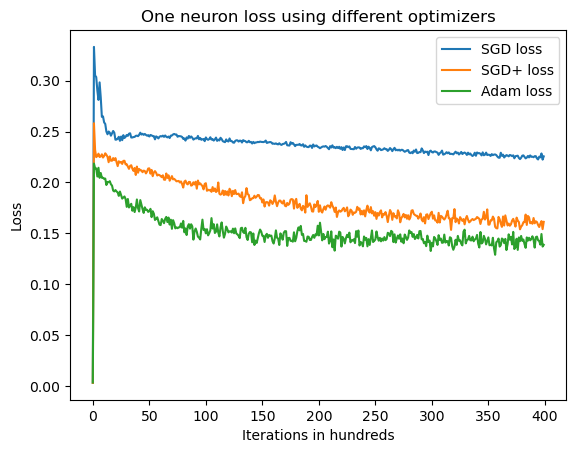

In [6]:
loss1 = cgp1.run_training_loop_one_neuron_model(training_data1)
plt.plot(loss1,label = "SGD loss")

loss2 = cgp1.run_training_loop_one_neuron_model(training_data1,0.9,True)
plt.plot(loss2,label = "SGD+ loss")

loss3 = cgp2.run_training_loop_one_neuron_model(training_data2,0.9,0.99)
plt.plot(loss3,label = "Adam loss")

plt.xlabel("Iterations in hundreds")
plt.ylabel("Loss")
plt.title("One neuron loss using different optimizers")

plt.legend(loc = "upper right")


